In [66]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
plt.rc('font',family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action='ignore')

df_raw=pd.read_csv('../data/raw_data/train.csv')
df=df_raw.copy()

sample_submission_raw=pd.read_csv('../data/raw_data/sample_submission.csv')
sample_submission=sample_submission_raw.copy()

In [67]:
df['일시']=pd.to_datetime(df['일시'],format="%Y%m%d")
df.set_index('일시',inplace=True)

df['일'] = df.index.day
df['월'] = df.index.month
df['년'] = df.index.year
df['요일']=df.index.day_of_week
df['주']=df.index.week

df['주말평일'] = df['요일'].apply(lambda x: '평일' if x < 5 else '주말')

# --

sample_submission['일시']=pd.to_datetime(sample_submission['일시'],format="%Y%m%d")
sample_submission.set_index('일시',inplace=True)

sample_submission['일'] = sample_submission.index.day
sample_submission['월'] = sample_submission.index.month
sample_submission['년'] = sample_submission.index.year
sample_submission['요일']=sample_submission.index.day_of_week
sample_submission['주']=sample_submission.index.week

sample_submission['주말평일'] = sample_submission['요일'].apply(lambda x: '평일' if x < 5 else '주말')

sample_submission['주']=sample_submission['주'].apply(lambda x: 1 if x==52 else x)

In [68]:
from pytimekr import pytimekr
def get_holiday(_year):
    holidays=[]
    for holiday in pytimekr.holidays(year=_year):
        if pytimekr.red_days(holiday) != None:
            ans = [i.strftime("%Y-%m-%d") for i in pytimekr.red_days(holiday)]
            holidays.extend(ans)
        else:
            ans=holiday.strftime("%Y-%m-%d")
            holidays.append(ans)
    return list(set(holidays))

In [69]:
df.loc[get_holiday(2018),'주말평일'] = '주말'
df.loc[get_holiday(2019),'주말평일'] = '주말'
df.loc[get_holiday(2020),'주말평일'] = '주말'
df.loc[get_holiday(2021),'주말평일'] = '주말'
sample_submission.loc[sorted(get_holiday(2022))[:-1],'주말평일'] ='주말'

In [74]:
df.to_csv('pps_data.csv')
sample_submission.to_csv('pps_target.csv')
sample_submission_raw.to_csv('sample_submission_raw.csv')

In [73]:
sample_submission_raw

,일시,광진구,동대문구,성동구,중랑구
0,20220101,0,0,0,0
1,20220102,0,0,0,0
2,20220103,0,0,0,0
3,20220104,0,0,0,0
4,20220105,0,0,0,0
...,...,...,...,...,...
329,20221126,0,0,0,0
330,20221127,0,0,0,0
331,20221128,0,0,0,0
332,20221129,0,0,0,0


In [70]:
weekly_mean=df.groupby(['주','주말평일'])[df.columns[:4]].mean()
weekly_mean=weekly_mean.reset_index()

In [6]:
temp=pd.merge(sample_submission,weekly_mean,on=['주말평일','주'])

temp['date'] = temp['년'].apply(lambda x : str(x)) + temp['월'].apply(lambda x : '_'+str(x).zfill(2)) + temp['일'].apply(lambda x : '_'+str(x).zfill(2))
temp.index=pd.to_datetime(temp['date'],format='%Y_%m_%d')
temp.sort_index(inplace=True)

weekly_mean_ans=temp.copy()

In [7]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [8]:
my=weekly_mean_ans.iloc[:,10:-1]

In [9]:
for col in my.columns:
    my[col][10:] = smooth(my[col],10)[10:]

In [49]:
df_2018_raw = df[df.index.year == 2018]
df_2019_raw = df[df.index.year == 2019]
df_2020_raw = df[df.index.year == 2020]
df_2021_raw = df[df.index.year == 2021]

In [50]:
df_2018_raw =df_2018_raw.groupby(['주','주말평일'])[df_2018_raw.columns[:4]].mean()
df_2019_raw =df_2019_raw.groupby(['주','주말평일'])[df_2019_raw.columns[:4]].mean()
df_2020_raw =df_2020_raw.groupby(['주','주말평일'])[df_2020_raw.columns[:4]].mean()
df_2021_raw =df_2021_raw.groupby(['주','주말평일'])[df_2021_raw.columns[:4]].mean()

In [51]:
df_2018_raw.columns = [str(i)+'2018' for i in df_2018_raw.columns]
df_2019_raw.columns = [str(i)+'2019' for i in df_2019_raw.columns]
df_2020_raw.columns = [str(i)+'2020' for i in df_2020_raw.columns]
df_2021_raw.columns = [str(i)+'2021' for i in df_2021_raw.columns]

In [52]:
from sklearn.preprocessing import MinMaxScaler
mms_2018 = MinMaxScaler()
mms_2019 = MinMaxScaler()
mms_2020 = MinMaxScaler()
mms_2021 = MinMaxScaler()


df_2018_raw.iloc[:,:] = mms_2018.fit_transform(df_2018_raw.iloc[:,:])
df_2019_raw.iloc[:,:] = mms_2019.fit_transform(df_2019_raw.iloc[:,:])
df_2020_raw.iloc[:,:] = mms_2020.fit_transform(df_2020_raw.iloc[:,:])
df_2021_raw.iloc[:,:] = mms_2021.fit_transform(df_2021_raw.iloc[:,:])

In [53]:
temp_1=pd.merge(df_2018_raw.reset_index(),df_2019_raw.reset_index(),on=['주','주말평일'])
temp_2=pd.merge(df_2020_raw.reset_index(),df_2021_raw.reset_index(),on=['주','주말평일'])

In [54]:
diff_df=pd.merge(temp_1,temp_2,on=['주','주말평일'])

In [61]:
df_diff_광진구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('광진구')] + ['주','주말평일']]
df_diff_동대문구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('동대문구')] + ['주','주말평일']]
df_diff_성동구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('성동구')] + ['주','주말평일']]
df_diff_중랑구=diff_df.loc[:,[i for i in diff_df.columns if i.startswith('중랑구')] + ['주','주말평일']]

In [62]:
df_diff_광진구['diff_mean_광진구']=df_diff_광진구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)
df_diff_동대문구['diff_mean_동대문구']=df_diff_동대문구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)
df_diff_성동구['diff_mean_성동구']=df_diff_성동구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)
df_diff_중랑구['diff_mean_중랑구']=df_diff_중랑구.iloc[:,:4].diff(axis=1).fillna(0).mean(axis=1)

In [58]:
my_diff=weekly_mean_ans.iloc[:,8:-1]

In [59]:
my_diff

,주,주말평일,광진구_y,동대문구_y,성동구_y,중랑구_y
date,,,,,,
2022-01-01,1,주말,1.446364,0.970182,1.088364,0.676364
2022-01-02,1,주말,1.446364,0.970182,1.088364,0.676364
2022-01-03,1,평일,1.870000,1.318000,1.704118,0.848941
2022-01-04,1,평일,1.870000,1.318000,1.704118,0.848941
2022-01-05,1,평일,1.870000,1.318000,1.704118,0.848941
...,...,...,...,...,...,...
2022-11-26,47,주말,4.552000,3.189000,3.430500,2.415250
2022-11-27,47,주말,4.552000,3.189000,3.430500,2.415250
2022-11-28,48,평일,5.241100,3.899100,4.223800,2.664300


<AxesSubplot: xlabel='date'>

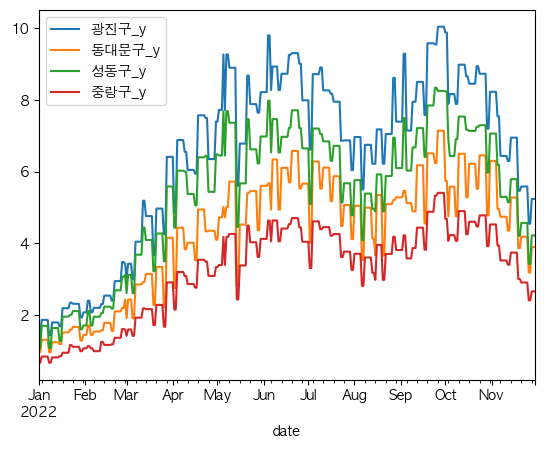

In [48]:
my_diff.iloc[:,2:].plot()

In [21]:
df_diff_광진구['ratio_1'] = df_diff_광진구.iloc[:,1]/df_diff_광진구.iloc[:,0]
df_diff_광진구['ratio_2'] = df_diff_광진구.iloc[:,2]/df_diff_광진구.iloc[:,1]
df_diff_광진구['ratio_3'] = df_diff_광진구.iloc[:,3]/df_diff_광진구.iloc[:,2]
df_diff_광진구['ratio_mean_광진']=df_diff_광진구.iloc[:,-3:].mean(axis=1)
###
df_diff_동대문구['ratio_1'] = df_diff_동대문구.iloc[:,1]/df_diff_동대문구.iloc[:,0]
df_diff_동대문구['ratio_2'] = df_diff_동대문구.iloc[:,2]/df_diff_동대문구.iloc[:,1]
df_diff_동대문구['ratio_3'] = df_diff_동대문구.iloc[:,3]/df_diff_동대문구.iloc[:,2]
df_diff_동대문구['ratio_mean_동대문']=df_diff_동대문구.iloc[:,-3:].mean(axis=1)
###
df_diff_성동구['ratio_1'] = df_diff_성동구.iloc[:,1]/df_diff_성동구.iloc[:,0]
df_diff_성동구['ratio_2'] = df_diff_성동구.iloc[:,2]/df_diff_성동구.iloc[:,1]
df_diff_성동구['ratio_3'] = df_diff_성동구.iloc[:,3]/df_diff_성동구.iloc[:,2]
df_diff_성동구['ratio_mean_성동']=df_diff_성동구.iloc[:,-3:].mean(axis=1)
###
df_diff_중랑구['ratio_1'] = df_diff_중랑구.iloc[:,1]/df_diff_중랑구.iloc[:,0]
df_diff_중랑구['ratio_2'] = df_diff_중랑구.iloc[:,2]/df_diff_중랑구.iloc[:,1]
df_diff_중랑구['ratio_3'] = df_diff_중랑구.iloc[:,3]/df_diff_중랑구.iloc[:,2]
df_diff_중랑구['ratio_mean_중랑']=df_diff_중랑구.iloc[:,-3:].mean(axis=1)

In [23]:
my['week']=my.index.week
my['weekday']=my.index.weekday
my['week']=my['week'].apply(lambda x: x if x!=52 else 1)

In [24]:
my['day_type']=my['weekday'].apply(lambda x : '평일' if x<5 else '주말' )

In [25]:
temp_1=my.merge(df_diff_광진구,left_on=['week','day_type'],right_on=['주','주말평일'])
temp_1['광진구_multiplied']=temp_1.iloc[:,0] * temp_1.iloc[:,-1]

In [26]:
temp_2=my.merge(df_diff_동대문구,left_on=['week','day_type'],right_on=['주','주말평일'])
temp_2['동대문구_multiplied']=temp_2.iloc[:,0] * temp_2.iloc[:,-1]

In [27]:
temp_3=my.merge(df_diff_성동구,left_on=['week','day_type'],right_on=['주','주말평일'])
temp_3['성동구_multiplied']=temp_3.iloc[:,0] * temp_3.iloc[:,-1]

In [28]:
temp_4=my.merge(df_diff_중랑구,left_on=['week','day_type'],right_on=['주','주말평일'])
temp_4['중랑구_multiplied']=temp_4.iloc[:,0] * temp_4.iloc[:,-1]

In [29]:
my_df=pd.concat([temp_1['광진구_multiplied'],temp_2['동대문구_multiplied'],temp_3['성동구_multiplied'],temp_4['중랑구_multiplied']],axis=1)

In [43]:
for col in my_df.columns:
    my_df[col] = smooth(my_df[col],7)